In [2]:
from matplotlib import pyplot as plt
from matplotlib import pylab
import numpy as np
import networkx as nx
from PIL import Image
from PIL import ImageDraw

%matplotlib inline

In [3]:
#Setting the seed for consistency for debugging
np.random.seed(53)

#Important variables
network_size = 1000 #side length of network boundaries
CNT_length_normal = 445 #normal length of CNT at center of distribution
CNT_length_stddev = 310 #standard deviation of CNT length from normal
CNT_num_tubes = 30 #number of tubes in film

CNT_init = np.zeros((CNT_num_tubes+2,7))

#creating the pseudo tubes that will act as the edges in the network
CNT_init[0:2,:] = [[network_size,0,0,0,0,network_size,0],
                   [network_size,0,1,0,network_size,network_size,network_size]]

#Generating tube information
#randomly assigning tube lengths distributed around a set tube length
logmean = np.log(CNT_length_normal / (np.sqrt(1+(CNT_length_stddev/CNT_length_normal)**2)))
logstdev = np.sqrt(np.log(1+(CNT_length_stddev/CNT_length_normal)**2))
CNT_init[2:,0] = np.random.lognormal(logmean, logstdev, CNT_num_tubes)

#randomly assign starting point and orientation
CNT_init[2:,1:4] = np.random.rand(CNT_num_tubes, 3)

#applying scaling to random numbers so they match the needed values
scaling_factor = np.array([1, network_size, network_size, 2*np.pi, 1, 1, 1])
CNT_init = CNT_init * scaling_factor

#calculating the x-max for the tubes
CNT_init[:,5] = CNT_init[:,1] + np.cos(CNT_init[:,3]) * CNT_init[:,0]

#calculating the y-max for the tubes
CNT_init[:,6] = CNT_init[:,2] + np.sin(CNT_init[:,3]) * CNT_init[:,0]

#calculating slope
CNT_init[:,3] = np.tan(CNT_init[:,3])

#calculating the y-intercept of the lines
CNT_init[:,4] = CNT_init[:,2] - CNT_init[:,3] * CNT_init[:,2]

print(CNT_init[:,2])
#delete this in final code this is just a reference to know what is in each column
#header = ['Length','x1','y1','slope','y-intercept','x2','y2']

[    0.          1000.           970.00412115   304.27576964   777.1799331
   267.68490455   220.84660171   725.78247462   819.04976507   853.9637824
   394.29315037   941.10301329   129.56341272   633.57783171   835.43402599
   707.9668992    895.71048181    61.00772763   710.93357806   897.76649414
   540.69283148   329.20279856   670.82990491   359.81006453   301.13836297
   261.7955265    371.56293639   344.48871919   544.78819189   125.15870157
    50.81015112    87.49118198]


In [4]:
#WORK ON FIXING SECOND Y-VALUES, THEY ARE ALL POSITIVE AND BETWEEN 0 AND 1000
#generating the endpoints for the tubes in the network
CNT_endpoints = np.zeros((CNT_num_tubes,4))
CNT_endpoints[:,0:2] = CNT_init[2:,1:3]
CNT_endpoints[:,2:4] = CNT_init[2:,5:7]

In [5]:
#generating a boolean array of the tubes that intersect
CNT_intersect = np.zeros((CNT_num_tubes,CNT_num_tubes),dtype=bool)
for i in range(0,CNT_num_tubes):
    m1 = CNT_init[i,3]
    b1 = CNT_init[i,4]
    for j in range(i+1,CNT_num_tubes):
        #checking for parallel tubes
        if m1 == CNT_init[j,3]:
            CNT_intersect[i,j] = False
            continue
        x_intersect = (CNT_init[j,4] - b1) / (m1 - CNT_init[j,3])
        y_intersect = CNT_init[i,3] * x_intersect + CNT_init[i,4] 
        
        if (CNT_init[i,1] <= x_intersect <= CNT_init[i,5] and 
            CNT_init[j,1] <= x_intersect <= CNT_init[j,5] and 
            0 <= x_intersect <= network_size and 
            0 <= y_intersect <= network_size):
            CNT_intersect[i,j] = True

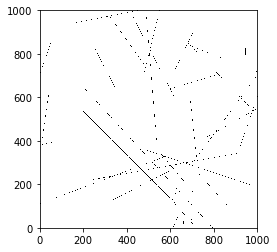

In [6]:
#size of image
image_size = (network_size, network_size) #pixles
#initializing a blank image
image = Image.new('RGBA', image_size, (255,255,255,255))
#selecting the image in which to draw and creating the drawing interface
draw = ImageDraw.Draw(image)
#setting the color for each line as black
color  = (0, 0, 0, 255)

#drawing the individual line segment on the image
for tube in CNT_endpoints:
    draw.line(((tube[0],tube[1]),(tube[2],tube[3])), fill=color, width=1)
    
#dislplaying the image
plt.imshow(np.asarray(image), origin='lower')
plt.show()
image.save('CNT_network_test.png')

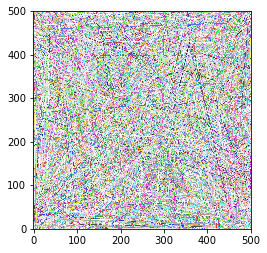

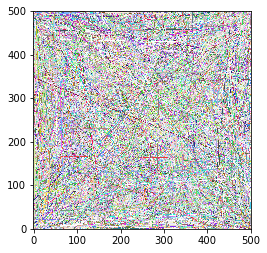

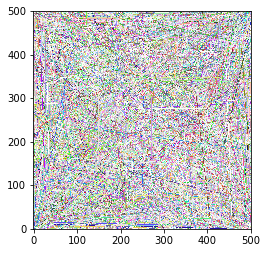

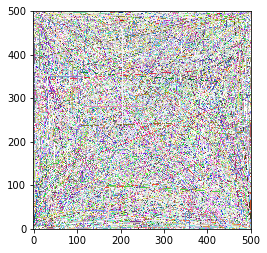

1 loop, best of 3: 892 ms per loop


In [7]:
%%timeit
#THIS IS THE EXAMPLE WITH NOTES FOR CLARITY
import random as rnd
#number of lines
N = 60000
#size of image
s = (500, 500)
#initializing a blank image
im = Image.new('RGBA', s, (255,255,255,255))
#selecting the image in which to draw and creating the drawing interface
draw = ImageDraw.Draw(im)

#generating random lines
for i in range(N):
    #scaling x and y values to be within allowable range
    x1 = rnd.random() * s[0]
    y1 = rnd.random() * s[1]
    x2 = rnd.random() * s[0]
    y2 = rnd.random() * s[1]
    
    #generating a random color for each line
    alpha = rnd.random()
    color  = (int(rnd.random() * 256), int(rnd.random() * 256), int(rnd.random() * 256), int(alpha * 256)) 
    
    #drawing the individual line segment on the image
    draw.line(((x1,y1),(x2,y2)), fill=color, width=1)

#dislplaying the image
plt.imshow(np.asarray(im), origin='lower')
plt.show()

Printing this boolean array will be a lot of information, especially as the number of tubes in the network grows. Since it is a boolean array and there are only two possible values, it will be easier to visualize and understand how many intersections there are by turning the array into an image where True is one color and False is another.

The number of intersections in the network is 14.
Below is a list where each element represents how many intersections the respective tube has:
[1 3 0 2 0 0 3 0 0 0 0 1 0 0 0 0 0 0 3 0 1 0 0 0 0 0 0 0 0 0]


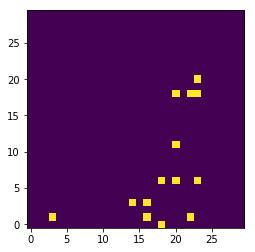

In [8]:
#THIS CELL IS ONLY FOR TROUBLESHOOTING, IT DOES NOT CODE FOR ANYTHING
#this cell visually shows the true values as yellow pixels
#generating a boolean array of the tubes that intersect
CNT_intersectALL = np.zeros((CNT_num_tubes,CNT_num_tubes),dtype=bool)
for i in range(0,CNT_num_tubes):
    m1 = CNT_init[i,3]
    b1 = CNT_init[i,4]
    for j in range(0,CNT_num_tubes):
        if i == j or m1 == CNT_init[j,3]:
            continue
        x_intersect = (CNT_init[j,4] - b1) / (m1 - CNT_init[j,3])
        if CNT_init[i,1] <= x_intersect <= CNT_init[i,5] and CNT_init[j,1] <= x_intersect <= CNT_init[j,5]:
            CNT_intersectALL[i,j] = True

pylab.imshow(CNT_intersect, origin='lower')
CNT_perTubeIntersect = np.sum(CNT_intersect,axis=1)
print('The number of intersections in the network is {}.'.format(np.sum(CNT_intersect)))
print('Below is a list where each element represents how many intersections the respective tube has:')
print(CNT_perTubeIntersect)

In [9]:
#gives the indicies along the x-axis of the true values as the 
#first array and the y-values as the second array
CNT_tube_num1, CNT_tube_num2 = np.where(CNT_intersect)
edges = [None]*np.sum(CNT_intersect)

#formatting the intersection data so it will fit work with networkX
for k in range(0,np.sum(CNT_intersect)):
    edges[k] = (CNT_tube_num1[k], CNT_tube_num2[k], {'resistance': 10.})
print(CNT_tube_num1)
print(CNT_tube_num2)
print(edges)

[ 0  1  1  1  3  3  6  6  6 11 18 18 18 20]
[18  3 16 22 14 16 18 20 23 20 20 22 23 23]
[(0, 18, {'resistance': 10.0}), (1, 3, {'resistance': 10.0}), (1, 16, {'resistance': 10.0}), (1, 22, {'resistance': 10.0}), (3, 14, {'resistance': 10.0}), (3, 16, {'resistance': 10.0}), (6, 18, {'resistance': 10.0}), (6, 20, {'resistance': 10.0}), (6, 23, {'resistance': 10.0}), (11, 20, {'resistance': 10.0}), (18, 20, {'resistance': 10.0}), (18, 22, {'resistance': 10.0}), (18, 23, {'resistance': 10.0}), (20, 23, {'resistance': 10.0})]


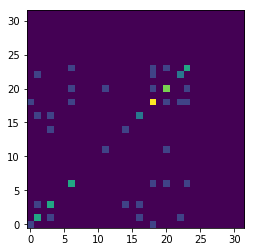

In [10]:
#generating a boolean array of the tubes that intersect and creating the G-matrix from that data
G_matrix = np.zeros((CNT_num_tubes+2,CNT_num_tubes+2),dtype=bool)
for i in range(0,CNT_num_tubes):
    m1 = CNT_init[i,3]
    b1 = CNT_init[i,4]
    for j in range(0,CNT_num_tubes):
        #Preventing errors from checking if a line intersects with itself
        if i == j or m1 == CNT_init[j,3]:
            continue
        x_intersect = (CNT_init[j,4] - b1) / (m1 - CNT_init[j,3])
        if CNT_init[i,1] <= x_intersect <= CNT_init[i,5] and CNT_init[j,1] <= x_intersect <= CNT_init[j,5]:
            G_matrix[i,j] = True
G_matrix = G_matrix * 2
for k in range(0,CNT_num_tubes):
    G_matrix[k,k] = np.sum(G_matrix[k,:])
pylab.imshow(G_matrix, origin='lower')

In [11]:
a = np.array([[3,1], [1,2]])
b = np.array([9,8])
x = np.linalg.solve(a, b)
print(a)
print(b)
print(x)

[[3 1]
 [1 2]]
[9 8]
[ 2.  3.]


In [12]:
# We will use the wonderfully useful library networkx to allow us
# to represent graphs in a nice way.

example_graph = nx.Graph()
example_graph.clear()
example_graph.add_nodes_from(list("ABCDEF"), current=0.) # initialize with all current = 0.
edges = [
    ('A', 'B', {'resistance': 10.}),
    ('A', 'C', {'resistance': 1.}),
    ('B', 'C', {'resistance': 3.}),
    ('B', 'D', {'resistance': 100.}),
    ('C', 'F', {'resistance': 1.}),
    ('D', 'E', {'resistance': 4.}),
    ('D', 'F', {'resistance': 1.}),
    ('E', 'F', {'resistance': 15.}),
]

example_graph.add_edges_from(edges)

In [13]:
#THIS CELL IS ONLY FOR TROUBLESHOOTING, IT DOES NOT CODE FOR ANYTHING
def num_intersect(network_size, CNT_length_normal, CNT_length_stddev, CNT_num_tubes, num_iterations=1000):
    """
    This function is for testing the number of intersections in the network
    generated with the given inputs.
    """
    #initializing empty array
    data = np.zeros(num_iterations)
    
    for k in range(0,num_iterations):
        #initializing data array
        CNT_init = np.zeros((CNT_num_tubes,6))

        #Generating tube information
        #randomly assigning tube lengths distributed around a set tube length
        CNT_init[:,0] = np.random.normal(CNT_length_normal, CNT_length_stddev, CNT_num_tubes)

        #randomly assign starting point and orientation
        CNT_init[:,1:4] = np.random.rand(CNT_num_tubes, 3)

        #applying scaling to random numbers so they match the needed values
        scaling_factor = np.array([1, network_size, network_size, 2*np.pi, 1, 1])
        CNT_init = CNT_init * scaling_factor

        #calculating the x-range for the tubes
        CNT_init[:,5] = np.cos(CNT_init[:,3]) * CNT_init[:,0]

        #calculating slope
        CNT_init[:,3] = np.tan(CNT_init[:,3])

        #calculating the y-intercept of the lines
        CNT_init[:,4] = CNT_init[:,2] - CNT_init[:,3] * CNT_init[:,2]

        #array_size = (CNT_init[:,0].size,CNT_init[0,:].size)
        CNT_intersect = np.zeros((CNT_num_tubes,CNT_num_tubes),dtype=bool)
        for i in range(0,CNT_num_tubes):
            m1 = CNT_init[i,3]
            b1 = CNT_init[i,4]
            for j in range(i+1,CNT_num_tubes):
                x_intersect = (CNT_init[j,4] - b1) / (m1 - CNT_init[j,3])
                if CNT_init[i,1] <= x_intersect <= CNT_init[i,5] and CNT_init[j,1] <= x_intersect <= CNT_init[j,5]:
                    CNT_intersect[i,j] = True
        data[k] = np.sum(CNT_intersect)
    plt.hist(data)
    plt.show()

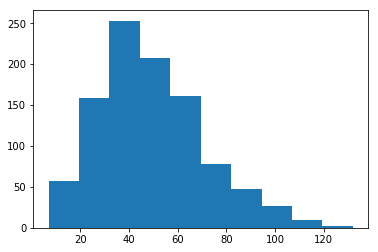

In [15]:
#THIS CELL IS ONLY FOR TROUBLESHOOTING, IT DOES NOT CODE FOR ANYTHING
#run this cell to get a histogram of the number of connections for the given conditions
network_size = 1000 #side length of network boundaries
CNT_length_normal = 1000 #normal length of CNT at center of distribution
CNT_length_stddev = 2 #standard deviation of CNT length from normal
CNT_num_tubes = 100 #number of tubes in film

num_intersect(network_size, CNT_length_normal, CNT_length_stddev, CNT_num_tubes)

In [ ]:
#THIS CELL IS OLD CODE AND IS NOT FOR USE IN THE FINAL PROGRAM
def intersect(EOL_1,EOL_2):
    #Calculates if two line segments intersect given two equations of lines given the
    #slopes, y-intercepts, and acceptable range
    #Input format: [slope, y_intercept, x_range]
    m1 = EOL_1[0] #slope of line 1
    m2 = EOL_2[0] #slope of line 2
    b1 = EOL_1[1] #Y-intercept of line 1
    b2 = EOL_2[1] #Y-intercept of line 2
    x_range_1 = EOL_1[2]
    x_range_2 = EOL_2[2]
    
    #Checking for parallel
    if m1 == m2:
        return False
    
    x_intersect = (b2 - b1) / (m1 - m2)
    
    return x_intersect in range(*x_range_1) and x_intersect in range(*x_range_2)

In [ ]:
#THIS CELL IS OLD CODE AND IS NOT FOR USE IN THE FINAL PROGRAM
def EOL(endpoint_1,endpoint_2):
    #Determines the slope, y-intercept of the parent line, and range of x-values of a line
    #segment made by 2 points. Endpoints are input as a list of x and y values e.g. [x,y]
    x1 = endpoint_1[0]
    y1 = endpoint_1[1]
    x2 = endpoint_2[0]
    y2 = endpoint_2[1]
    
    #Preventing undefined values for infinite slope
    if x1 == x2:
        slope = 1e10
    else:
        slope = (y2 - y1) / (x2 - x1)
    y_intercept = y1 - slope * x1
    #finding range of x-values the segment runs for to make determining intersection easier
    x_range = [np.min(x1,x2),np.max(x1,x2)]
    return slope, y_intercept, x_range

In [16]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
